# Практическое задание №3 по теме "TensorFlow".

<ol>
    <li>Попробуйте улучшить работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST.</li>
    <li>Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора) на датасет from sklearn.datasets import load_boston.</li>
    <li>Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?</li>
</ol>

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.nn as nn
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.random.set_seed(123)

## Задание 1

Улучшим работу нейронной сети (разобранную на уроке), обучавшейся на датасет Fashion-MNIST

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

train_images = train_images / 255.0 # нормировка по диапазону [0, 1]
test_images = test_images / 255.0

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10) # если нет активации, значит выход ЛИНЕЙНЫЙ
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 5s 2ms/step - loss: 0.4992 - accuracy: 0.8242
Epoch 2/3
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3747 - accuracy: 0.8659
Epoch 3/3
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3366 - accuracy: 0.8779


In [6]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.4059 - accuracy: 0.8479 - 760ms/epoch - 2ms/step

Test accuracy: 0.8478999733924866


Пытаемся улучшить нашу нейросеть, улучшив некоторые параметры:

In [7]:
better_model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax'),
])

better_model.compile(optimizer='adam',
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

better_model_history = better_model.fit(train_images, to_categorical(train_labels, 10), epochs=5, 
                 batch_size=512, verbose=0, validation_split=0.2)

In [8]:
test_loss, test_acc = better_model.evaluate(test_images, to_categorical(test_labels, 10), verbose=0)

print('\nTest accuracy:', test_acc)


Test accuracy: 0.8712999820709229


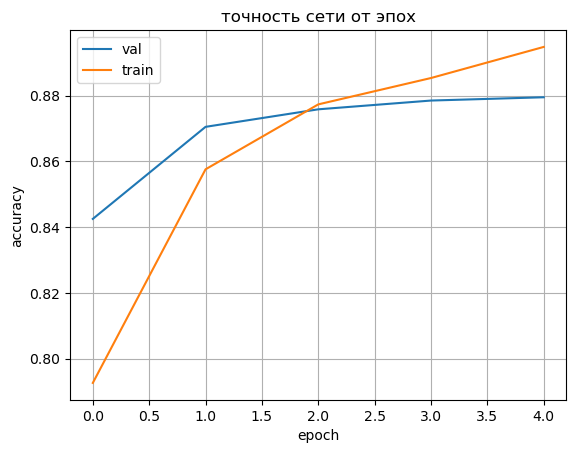

In [9]:
plt.plot(better_model_history.history['val_accuracy'], label='val')
plt.plot(better_model_history.history['accuracy'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('точность сети от эпох')
plt.grid()
plt.show()

Добавив слой, количество нейронов, изменив функцию активации выходного слоя, удалось улучшить качество сетки.

## Задание 3

In [10]:
boston = keras.datasets.boston_housing

(X_train, y_train), (X_test, y_test) = boston.load_data()

train_images = train_images / 255.0 # нормировка по диапазону [0, 1]
test_images = test_images / 255.0

In [11]:
# Масштабирование
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Видим, что нужно будет решить задачу регрессии. Это значит, что функция активация не может быть, например, сигмоидной функцией, которая ограничена сверху. В качестве функции потерь лучше всего рассматривать среднеквадратичную ошибку (MSE) + так советовали сделать в вебинаре.

Рассмотрим разные варианты (48 вариантов):

* Количество слоев (layers_list): 3, 5 и 10 <br>
* Количество нейронов (neurons_list): 16, 64 и 128, 512 <br>
* Функция активации (act_func_list): relu, tanh <br>
* Метод оптимизации (opt_list): RMSProp, Adam<br>

In [12]:
layers_list = [3, 5, 10]
neurons_list = [8, 16, 32, 64, 128]
act_func_list = ['relu', 'tanh']
opt_list = ['RMSProp', 'Adam']

Для проверки переобучения будем выводить графики качества train/test

In [13]:
# Заполняем сводную таблицу результатов
results = pd.DataFrame() 
n_layers = [] 
n_neurons = [] 
act_func = [] 
optimizers = [] 
train_mse = []
test_mse = [] 

In [14]:
def create_multiply_layers_model(layers_number : int, activation_func : str, neurons_number: int, optimizer: str):
    model = Sequential()
    model.add(Flatten(input_shape=(13,)))
    for i in range(layers_number):
        model.add(Dense(neurons_number, activation=activation_func))
    model.add(keras.layers.Dense(1, activation=activation_func))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])
    return model

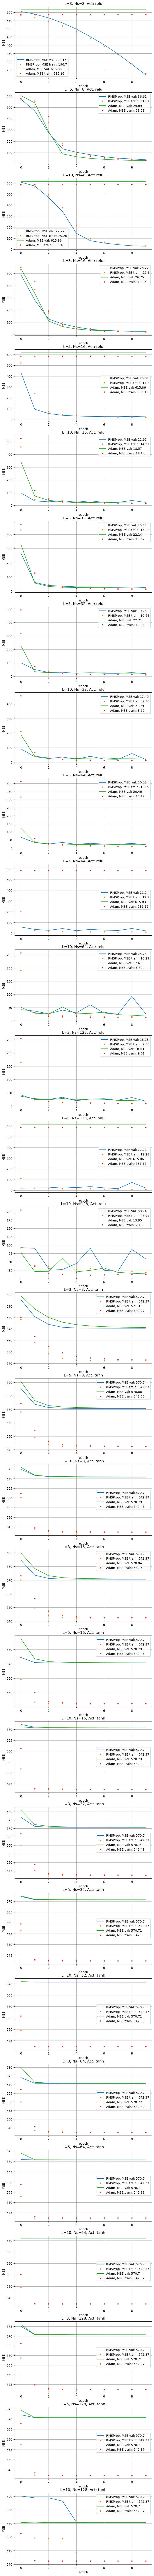

In [15]:
subs_number = len(act_func_list)*len(neurons_list)*len(layers_list)
plt.figure(figsize=(8, 5*subs_number))
k=1
for a_f in act_func_list:
    for n_n in neurons_list:
        for n_l in layers_list:
            plt.subplot(subs_number, 1, k)
            for opt in opt_list:
                n_layers.append(n_l)
                n_neurons.append(n_n)
                act_func.append(a_f)
                optimizers.append(opt)
                
                model_tmp = create_multiply_layers_model(n_l, a_f, n_n, opt)
                history = model_tmp.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test), verbose=0)
                
                tr_loss, tr_mse = model_tmp.evaluate(X_train, y_train, verbose=0)
                te_loss, te_mse = model_tmp.evaluate(X_test, y_test, verbose=0)
                train_mse.append(tr_mse)
                test_mse.append(te_mse)
                
                plt.plot(history.history['val_mse'], label=f'{opt}, MSE val: {round(te_mse, 2)}')
                plt.plot(history.history['mse'], '.', label=f'{opt}, MSE train: {round(tr_mse, 2)}')
    
            plt.xlabel('epoch')
            plt.ylabel('MSE')
            plt.grid()
            plt.legend()
            plt.title(f"L={n_l}, Ns={n_n}, Act: {a_f}")                
            k += 1

Сводная таблица результатов:

In [16]:
results['n_layers'] = n_layers
results['n_neurons'] = n_neurons
results['act_func'] = act_func
results['optimizers'] = optimizers
results['train_mse'] = train_mse
results['test_mse'] = test_mse
results['overfitting'] = results['test_mse'] - results['train_mse']

In [17]:
results.sort_values(by=['test_mse','overfitting'], ascending=[True, True])

,n_layers,n_neurons,act_func,optimizers,train_mse,test_mse,overfitting
29,10,128,relu,Adam,7.181199,13.952936,6.771737
16,10,32,relu,RMSProp,9.361252,17.490765,8.129513
23,10,64,relu,Adam,8.522879,17.611984,9.089106
24,3,128,relu,RMSProp,9.560914,18.178699,8.617785
25,3,128,relu,Adam,9.008861,18.432339,9.423478
11,10,16,relu,Adam,14.176571,18.568272,4.391701
14,5,32,relu,RMSProp,10.637798,19.747736,9.109938
19,3,64,relu,Adam,10.118380,20.457697,10.339317
18,3,64,relu,RMSProp,10.890578,20.546621,9.656043
20,5,64,relu,RMSProp,12.901344,21.243406,8.342062


**Вывод:**

* Лучшее качество получилось на максимальном количестве слоев (10) и максимальном количестве нейронов (128).
* Наименьшая ошибка получилась с оптимизатором Adam. 
* Наименьшая ошибка получилась с функцией активацией ReLU.
* Точность увеличивается с ростом числа слоев и числа нейронов.
* Все еще сложно понять как грамотно выбирать оптимизаторы, поскольку у оптимизаторов есть и свои гиперпараметры. В данном задании мы это не учитывали.
* Также нужно аккуратно выбирать количество эпох, поскольку переобучение возникает довольно быстро.

## Задание 2

Для датасета boston построим наилучшую по результатам задания №3 нейронную сеть.

In [61]:
best_model = create_multiply_layers_model(10, 'relu', 128, 'Adam')

In [62]:
best_history = best_model.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test), verbose=0)

best_model.evaluate(X_train, y_train, verbose=2)
best_model.evaluate(X_test, y_test, verbose=2)

13/13 - 0s - loss: 7.7384 - mse: 7.7384 - 63ms/epoch - 5ms/step
4/4 - 0s - loss: 13.2297 - mse: 13.2297 - 31ms/epoch - 8ms/step


[13.229711532592773, 13.229711532592773]

In [63]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

4/4 [==============================] - 0s 4ms/step


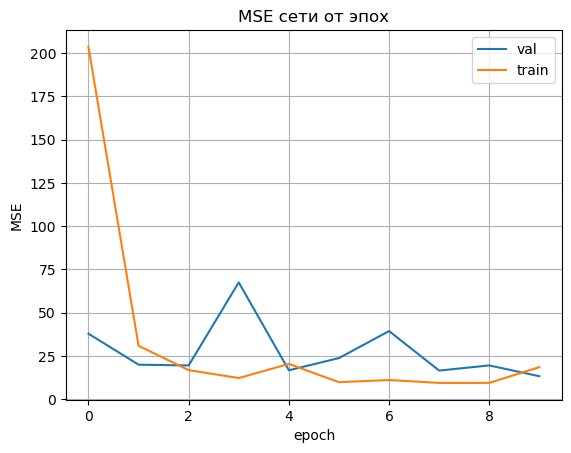

In [64]:
plt.plot(best_history.history['val_mse'], label='val')
plt.plot(best_history.history['mse'], label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('MSE сети от эпох')
plt.grid()
plt.show()

In [65]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f'Train R2: {round(r2_train,2)}')
print(f'Test R2: {round(r2_test,2)}')

Train R2: 0.91
Test R2: 0.84


Получили довольно неплохого качества модель.

---